In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder\
    .master("local[*]")\
    .appName("Midterm Project")\
    .getOrCreate()

print("Spark Session created successfully!")
spark

Spark Session created successfully!


In [3]:
from google.colab import files

uploaded = files.upload()

Saving articles.csv to articles.csv
Saving transactions-2p-42.csv to transactions-2p-42.csv


In [4]:
from pyspark.sql.functions import col, sum, when, count, to_date, year, countDistinct, lit
from pyspark.sql.types import DateType

In [5]:
#Data Quality

In [6]:
transactions_df = spark.read.csv(
    "transactions-2p-42.csv",
    header=True,
    inferSchema=True
)
articles_df = spark.read.csv(
    "articles.csv",
    header=True,
    inferSchema=True
)

In [7]:
print("--- Transactions DataFrame: Head and Schema ---")
transactions_df.show(5, truncate=False)
transactions_df.printSchema()

print("\n--- Articles DataFrame: Head and Schema ---")
articles_df.show(5, truncate=False)
articles_df.printSchema()

--- Transactions DataFrame: Head and Schema ---
+----------+----------------------------------------------------------------+----------+------------------+----------------+
|t_dat     |customer_id                                                     |article_id|price             |sales_channel_id|
+----------+----------------------------------------------------------------+----------+------------------+----------------+
|2019-07-24|192e9ad7f0c05d89e3321a3a8caa990f19cf761ad0d13794a31202b8d012939f|692721005 |0.0121864406779661|2               |
|2019-04-07|70c1ee207c64a65234a6832a42a66a6f9bae6fbf2061216cbe4461cc5afcccb0|599502013 |0.0508305084745762|2               |
|2019-05-21|e29656435a0c04ef196d7218d1ec18d800f1ff382b9442b144e47665d338f50a|737260001 |0.0254067796610169|2               |
|2019-03-29|13d1fd878959e117e6b416cba433e1b9b2867f3a423fa5dd7fb8efc1ccf500f3|717251003 |0.0169322033898305|2               |
|2019-07-05|58ddbcfa96eab2b3aaf2e05ce2148246b2f97002c50c0c3a91743d2043af6ad9|

In [8]:
all_transaction_cols = transactions_df.columns

transactions_all_null_counts = transactions_df.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in all_transaction_cols]
).collect()[0].asDict()

print("--- Null Counts for ALL transactions-2p-42.csv Columns ---")
all_zero = True
for col_name, null_count in transactions_all_null_counts.items():
    if null_count > 0:
        print(f"  {col_name}: {null_count}")
        all_zero = False

if all_zero:
    print("  All columns have ZERO null values. Data quality is excellent.")

--- Null Counts for ALL transactions-2p-42.csv Columns ---
  All columns have ZERO null values. Data quality is excellent.


In [10]:
all_article_cols = articles_df.columns

articles_all_null_counts = articles_df.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in all_article_cols]
).collect()[0].asDict()

for col_name, null_count in articles_all_null_counts.items():
    if null_count > 0:
        print(f"  {col_name}: {null_count}")

  detail_desc: 416


In [12]:
#The transactional data is fully complete, while the article data has only minor incompleteness, specifically 416 null values in the detail_desc column.

In [13]:
#We have to change the type of t_dat from text to date.

In [14]:
from pyspark.sql.functions import col, to_date

transactions_clean_df = transactions_df.withColumn(
    "t_dat",
    to_date(col("t_dat"), "yyyy-MM-dd")
)

transactions_clean_df.printSchema()

root
 |-- t_dat: date (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- article_id: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- sales_channel_id: integer (nullable = true)



In [15]:
#Checking for Join Mismatches

In [16]:
orphan_transactions_count = transactions_clean_df.join(
    articles_df,
    on="article_id",
    how="left_anti"
).count()

total_transactions = transactions_clean_df.count()

print("--- Join Integrity Check ---")
print(f"Total transactions in sample: {total_transactions}")
print(f"Transactions without a matching article_id: {orphan_transactions_count}")
print(f"Percentage mismatch: {(orphan_transactions_count / total_transactions * 100):.4f}%")

--- Join Integrity Check ---
Total transactions in sample: 336078
Transactions without a matching article_id: 0
Percentage mismatch: 0.0000%


In [17]:
#The Left Anti Join is a filtering operation that exclusively returns the set of rows from the left DataFrame (transactions_clean_df) where the join key (article_id) is absent in the right DataFrame (articles_df)

In [18]:
#Checking outliers for "price" column

In [19]:
transactions_df.describe("price").show()

+-------+--------------------+
|summary|               price|
+-------+--------------------+
|  count|              336078|
|   mean|0.027498519008053526|
| stddev| 0.01921244097171475|
|    min|   1.864406779661E-4|
|    max|  0.5067796610169492|
+-------+--------------------+



In [20]:
#The maximum price  is an extreme outlier, showing it's much higher than what most products sell for.
#The minimum price is positive, meaning every item sold in the sample had a correct

In [21]:
transactions_df.groupBy("sales_channel_id").count().orderBy("sales_channel_id").show()

+----------------+------+
|sales_channel_id| count|
+----------------+------+
|               1|103464|
|               2|232614|
+----------------+------+



In [22]:
#We can conclude that 69.22% of all transactions originate from Sales Channel 2

In [23]:
#What are the product trend changes through (3 points)
   # a. seasons of the year
   # b. the years

In [24]:
from pyspark.sql.functions import col, year, month, sum, lit, when

In [25]:
# a. seasons of the year

In [26]:
#Doing inner join

In [27]:
master_df = transactions_clean_df.join(
    articles_df.select("article_id", "product_group_name", "index_name"),
    on="article_id",
    how="inner"
).withColumn("purchase_year", year(col("t_dat")))\
 .withColumn("purchase_month", month(col("t_dat")))


In [28]:
master_df

DataFrame[article_id: int, t_dat: date, customer_id: string, price: double, sales_channel_id: int, product_group_name: string, index_name: string, purchase_year: int, purchase_month: int]

In [29]:
#Define Seasons

In [32]:
trend_df = master_df.withColumn(
    "season",
    when(col("purchase_month").isin(lit(3), lit(4), lit(5)), lit("Spring"))
    .when(col("purchase_month").isin(lit(6), lit(7), lit(8)), lit("Summer"))
    .when(col("purchase_month").isin(lit(9), lit(10), lit(11)), lit("Autumn"))
    .otherwise(lit("Winter"))
)

In [33]:
#Aggregation total revenue by Season and Product Group

In [38]:
season_trend = trend_df.groupBy("season", "product_group_name")\
    .agg(sum("price").alias("total_revenue"))\
    .orderBy(col("season"), col("total_revenue").desc())

print("\n--- A. Product Trend Changes by Season (Top 50) ---")
season_trend.show(50, truncate=False)


--- A. Product Trend Changes by Season (Top 50) ---
+------+-------------------+--------------------+
|season|product_group_name |total_revenue       |
+------+-------------------+--------------------+
|Autumn|Garment Upper body |1227.381999999985   |
|Autumn|Garment Lower body |616.2010508474555   |
|Autumn|Garment Full body  |227.38094915254277  |
|Autumn|Underwear          |122.67283050847382  |
|Autumn|Shoes              |87.1528305084747    |
|Autumn|Accessories        |77.69566101694934   |
|Autumn|Nightwear          |27.74450847457622   |
|Autumn|Socks & Tights     |27.54561016949132   |
|Autumn|Swimwear           |26.142525423728685  |
|Autumn|Unknown            |1.2983728813559297  |
|Autumn|Bags               |0.3461186440677959  |
|Autumn|Items              |0.0863389830508472  |
|Autumn|Underwear/nightwear|0.0677627118644066  |
|Autumn|Cosmetic           |0.044305084745762294|
|Autumn|Interior textile   |0.0169322033898305  |
|Spring|Garment Upper body |796.6026440677904  

In [42]:
#Product trends show Garment Upper body is the consistent top revenue driver across all seasons, while Swimwear exhibits a pronounced seasonal shift, generating its highest sales during the Spring and Summer months.

In [ ]:
#Product trends show Garment Upper body is the consistent top revenue driver across all seasons, while Swimwear exhibits a pronounced seasonal shift, generating its highest sales during the Spring and Summer months.

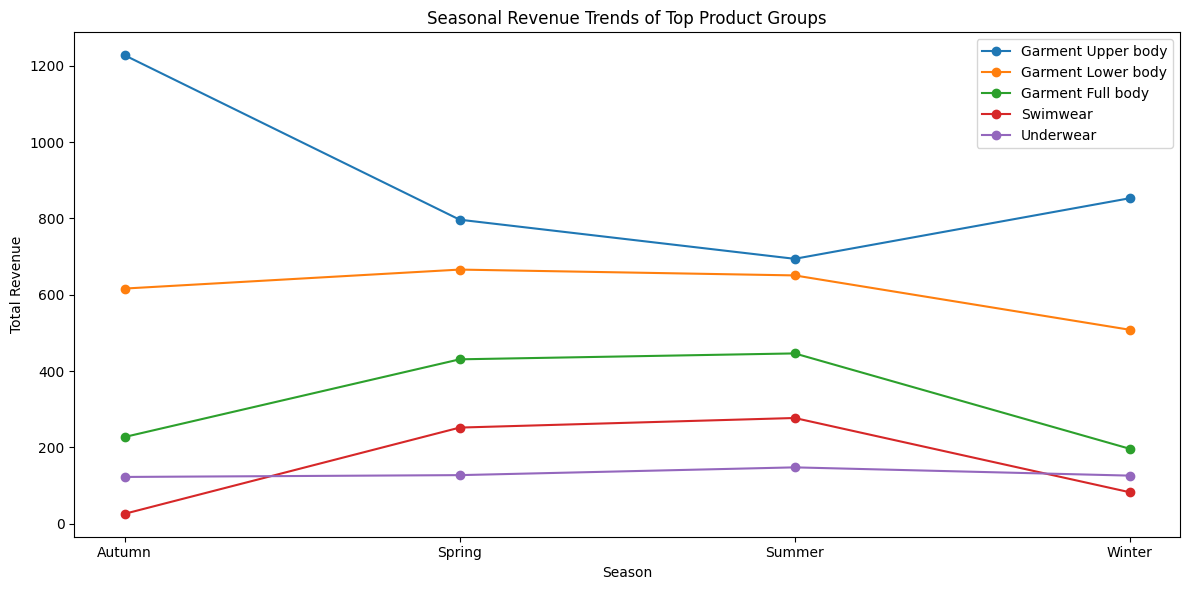

In [46]:
plt.figure(figsize=(12,6))

for group in top_groups:
    subset = filtered_pdf[filtered_pdf["product_group_name"] == group]
    plt.plot(subset["season"], subset["total_revenue"], marker="o", label=group)

plt.title("Seasonal Revenue Trends of Top Product Groups")
plt.xlabel("Season")
plt.ylabel("Total Revenue")
plt.legend()
plt.tight_layout()
plt.show()

In [49]:
#Aggregation total revenue by Year and Product Group

In [50]:
year_trend = trend_df.groupBy("purchase_year", "product_group_name")\
    .agg(sum("price").alias("total_revenue"))\
    .orderBy(col("purchase_year"), col("total_revenue").desc())

print("\n--- B. Product Trend Changes by Year (Top 50) ---")
year_trend.show(50, truncate=False)


--- B. Product Trend Changes by Year (Top 50) ---
+-------------+-------------------+-------------------+
|purchase_year|product_group_name |total_revenue      |
+-------------+-------------------+-------------------+
|2018         |Garment Upper body |1318.7904406779617 |
|2018         |Garment Lower body |646.2308135593173  |
|2018         |Garment Full body  |252.7640847457632  |
|2018         |Underwear          |141.2368644067784  |
|2018         |Shoes              |93.36316949152548  |
|2018         |Accessories        |91.40516949152514  |
|2018         |Socks & Tights     |35.029355932203245 |
|2018         |Nightwear          |34.77883050847453  |
|2018         |Swimwear           |29.278593220338866 |
|2018         |Unknown            |1.5160338983050816 |
|2018         |Bags               |0.10164406779660991|
|2018         |Cosmetic           |0.06883050847457561|
|2018         |Items              |0.0623220338983049 |
|2018         |Underwear/nightwear|0.0558983050847456

In [56]:
pdf = year_trend.toPandas()

top_groups = (
    pdf.groupby("product_group_name")["total_revenue"]
       .sum()
       .sort_values(ascending=False)
       .head(5)
       .index
)

filtered_pdf = pdf[pdf["product_group_name"].isin(top_groups)]

In [57]:
pivot_df = filtered_pdf.pivot(
    index="purchase_year",
    columns="product_group_name",
    values="total_revenue"
)

In [58]:
pivot_norm = pivot_df.div(pivot_df.sum(axis=1), axis=0)

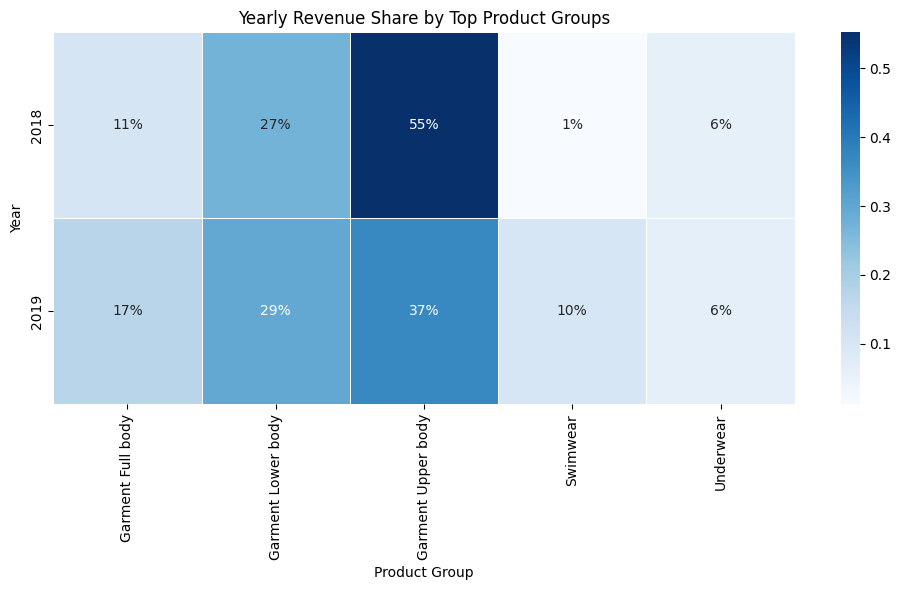

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

sns.heatmap(
    pivot_norm,
    cmap="Blues",
    annot=True,
    fmt=".0%",
    linewidths=0.5
)

plt.title("Yearly Revenue Share by Top Product Groups")
plt.xlabel("Product Group")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

In [60]:
#2. Suggest a methodology and make an estimate for the whole data given that transactions.csv is a random sample of 3%
#from the entire population (3 points). Estimate
 #   a. total revenue
 #  b. number of customers
 # c. number of transactions
#d. average expenses per year per customer

In [61]:
from pyspark.sql.functions import sum, countDistinct, lit, count, to_date, year, col

In [62]:
# Define the scaling factor
EXTRAPOLATION_FACTOR = 1 / 0.03

In [64]:
#Calculate Sample Metrics
sample_metrics = transactions_df.agg(
    sum("price").alias("sample_total_revenue"),
    countDistinct("customer_id").alias("sample_total_customers"),
    count(lit(1)).alias("sample_total_transactions")
).collect()[0]

In [65]:
# Extract Sample Values
S_Revenue = sample_metrics["sample_total_revenue"]
S_Customers = sample_metrics["sample_total_customers"]
S_Transactions = sample_metrics["sample_total_transactions"]

In [66]:
#Determine the number of years in the sample for calculation average expenses per year per customer

In [67]:
dates_df = transactions_df.withColumn("t_dat", to_date(col("t_dat"), "yyyy-MM-dd"))

In [68]:
min_year_val = dates_df.select(year("t_dat")).agg({"year(t_dat)": "min"}).collect()[0][0]
max_year_val = dates_df.select(year("t_dat")).agg({"year(t_dat)": "max"}).collect()[0][0]

In [69]:
NUM_YEARS = max_year_val - min_year_val + 1
# Handle case where date range is minimal or calculation is zero
if NUM_YEARS == 0 or NUM_YEARS is None: NUM_YEARS = 1

In [70]:
#total revenue, number of customers,number of transactions are scaled

In [71]:
E_Revenue = S_Revenue * EXTRAPOLATION_FACTOR
E_Customers = S_Customers * EXTRAPOLATION_FACTOR
E_Transactions = S_Transactions * EXTRAPOLATION_FACTOR

In [72]:
#average expenses per year per customer is a sample average, NOT scaled

In [73]:
Avg_Expenses_Per_Year_Per_Customer = S_Revenue / (S_Customers * NUM_YEARS)

In [74]:
print("\n--- Estimated Population Metrics (3% Sample) ---")
print(f"Extrapolation Factor (F): {EXTRAPOLATION_FACTOR:.3f}")
print("-" * 60)
print(f"a. Estimated Total Revenue: ${E_Revenue:,.2f}")
print(f"b. Estimated Number of Customers: {E_Customers:,.0f}")
print(f"c. Estimated Number of Transactions: {E_Transactions:,.0f}")
print("-" * 60)
print(f"d. Average Expenses per Year Per Customer (Sample Average): ${Avg_Expenses_Per_Year_Per_Customer:.4f}")


--- Estimated Population Metrics (3% Sample) ---
Extrapolation Factor (F): 33.333
------------------------------------------------------------
a. Estimated Total Revenue: $308,054.91
b. Estimated Number of Customers: 7,689,600
c. Estimated Number of Transactions: 11,202,600
------------------------------------------------------------
d. Average Expenses per Year Per Customer (Sample Average): $0.0200


#Given that the transactions dataset is a random 3% sample of the full population,
#we assume representativeness across customers, products, and time periods.
#Therefore, aggregate metrics were extrapolated using a scaling factor of ~33.3.

In [82]:
#Final conclusion
#The company is estimated to serve nearly 7.7$ million customers.This massive number means the company has a huge market reach.
#The company sells a huge amount of stuff, with over $11$ million estimated transactions.
#All these transactions generate an estimated Total Revenue of over 308,000$.
#The average expense per customer per year is estimated at a very low.
#we know the prices are normalized, this low number means that, on average, customers are making many small-value purchases.

In [90]:
#Extra 2 points for more findings and creative work

In [92]:
try:
    df_transactions = pd.read_csv('transactions-2p-42.csv')
    df_transactions['t_dat'] = pd.to_datetime(df_transactions['t_dat'])
except FileNotFoundError:
    print("Error: 'transactions-2p-42.csv' not found.")
    raise

# --- 1. Define Analysis Date and Calculate RFM Metrics ---
snapshot_date = df_transactions['t_dat'].max() + pd.Timedelta(days=1)

# Calculate RFM
rfm_df = df_transactions.groupby('customer_id').agg(
    Recency=('t_dat', lambda x: (snapshot_date - x.max()).days),
    Frequency=('article_id', 'count'),
    Monetary=('price', 'sum')
).reset_index()

# --- 2. Calculate RFM Quartiles (Q-scores) using robust qcut ---
# R_Score (Recency: Lower days is better -> higher score: 4, 3, 2, 1)
r_labels = range(4, 0, -1)
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], q=4, labels=r_labels, duplicates='drop').astype(int)

# F_Score and M_Score (Higher value is better -> higher score: 1, 2, 3, 4)
# Use .cat.codes + 1 for robustness against duplicates (many customers have F=1 and M=low value)
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'], q=4, duplicates='drop').cat.codes + 1
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], q=4, duplicates='drop').cat.codes + 1

def rfm_segment(row):
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    if r == 4 and f == 4 and m == 4:
        return 'Champions'
    elif r == 4 and (f >= 3 and m >= 3):
        return 'Loyal/Promising'
    elif r == 4 and (f <= 2 or m <= 2):
        return 'New Customers'
    elif (r >= 2) and (f <= 2 and m <= 2):
        return 'Need Attention'
    elif (r == 1) and (f >= 3 and m >= 3):
        return 'At Risk/Can\'t Lose'
    else:
        return 'Other Segment'

rfm_df['RFM_Segment'] = rfm_df.apply(rfm_segment, axis=1)

segment_counts = rfm_df.groupby('RFM_Segment').agg(
    Customer_Count=('customer_id', 'count'),
    Total_Spend=('Monetary', 'sum')
).reset_index()

In [93]:
# Percentage of total spend by segment
total_spend_all = segment_counts['Total_Spend'].sum()
segment_counts['Spend_Percentage'] = (segment_counts['Total_Spend'] / total_spend_all) * 100
segment_counts = segment_counts.sort_values(by='Total_Spend', ascending=False)

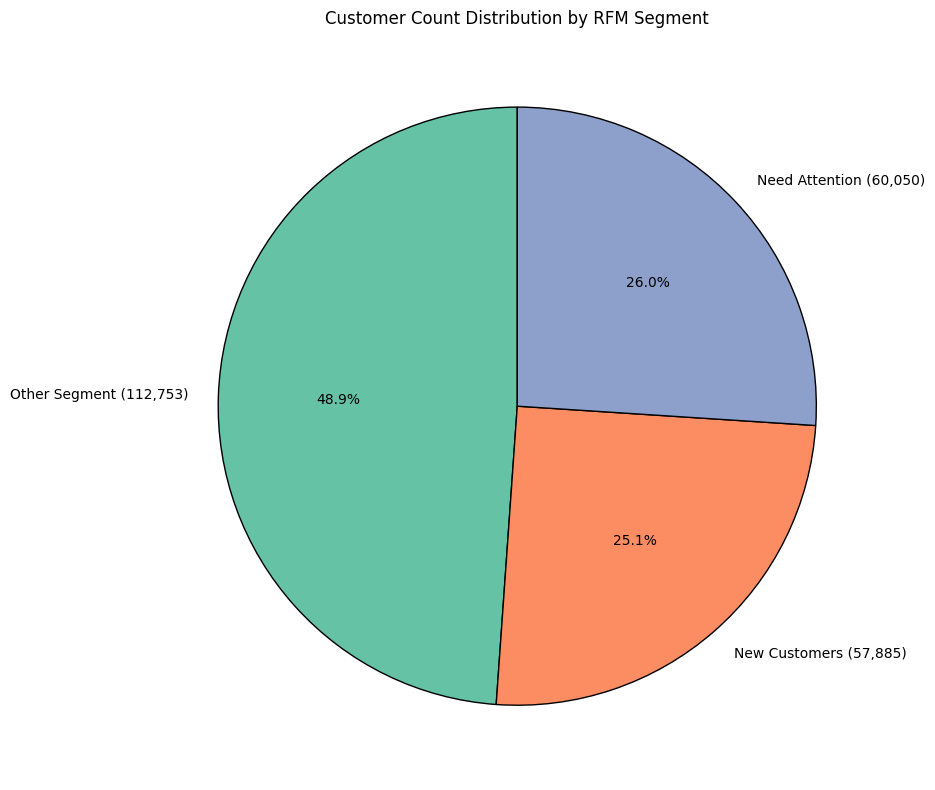

In [98]:
plt.figure(figsize=(10, 8))
plt.pie(
    segment_counts['Customer_Count'],
    labels=[f"{s} ({c:,})" for s, c in zip(segment_counts['RFM_Segment'], segment_counts['Customer_Count'])],
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("Set2"),
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Customer Count Distribution by RFM Segment')
plt.tight_layout()
plt.savefig('rfm_customer_count_pie.png')
plt.show()

In [100]:
#conclusion
#Other Segment: This group is the most valuable because they include our top-spending, most loyal customers who generate over half of the total revenue.

#Need Attention Segment: This is a huge group of customers who bought somewhat recently but spent very little and only once or twice, so we need to target them with campaigns to increase their purchases before they stop buying altogether.